In [3]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis")
print(os.getcwd())


E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis


In [4]:
#Array packages
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy


In [61]:
mdl=2
model_n=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5"]

#Readingg model output and shapefiledata
lsm_M = xr.open_mfdataset(f"DATA_p/{model_n[mdl]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm_M=lsm_M*60*60*24*30 #converting to mm/ month
lsm_M=lsm_M.where(lsm_M>=0) 
lsm_M=lsm_M[['TotalPrecip_tavg','Evap_tavg','Qs_tavg']]
RE=lsm_M["Qs_tavg"]/lsm_M["TotalPrecip_tavg"]
RE=RE.where(RE<0.7,0)
lsm_M = xr.merge([lsm_M, RE.rename("RE")])
#lsm_M=lsm_M.interpolate_na(dim="time", method="linear") # filling nan values
lsm_M=lsm_M.compute() 

lsm_monthly  =  lsm_M.groupby('time.month')
lsm_mean     =  lsm_M.groupby('time.month').mean(dim='time')
lsm_anom = lsm_monthly-lsm_mean  
lsm_std  = lsm_M.groupby('time.month').std(dim='time')
lsm_norm = (lsm_anom.groupby('time.month'))/lsm_std

ds=lsm_norm 

gdf = gpd.read_file('DATA_p/Shapefiles/India_trans/India_trans_new.shp')
basin=np.array(gdf.iloc[:,2])

dataset=[]
for i in range(len(basin)):
    
    B=gdf[gdf['Basin'] == basin[i]]
    ds.rio.set_spatial_dims(y_dim="lat",x_dim="lon", inplace=True)
    ds.rio.write_crs("EPSG:4326", inplace=True)
    clipped_ds = ds.rio.clip(B.geometry.apply(mapping), B.crs, drop=True)
    A=clipped_ds.mean(dim=['lat','lon']).expand_dims(dim='region')
    dataset.append(A)
    
ds_RM = xr.concat(dataset, dim='region')
# Add 'region' coordinate to ds_R
ds_RM['region'] = basin


C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [64]:
import pymannkendall as mk
from sklearn.linear_model import LinearRegression

df = pd.DataFrame({"Basin" : basin, "slope": 0, "p_value": 0})
result=[]

for i in range(0,len(basin)):

    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(ds_RM['RE'].sel(region=basin[i]))
    df["slope"][i]=slope
    df["p_value"][i]=p


    model=LinearRegression().fit(np.array(range(len(ds_RM['time'].values))).reshape(-1, 1),ds_RM['RE'].sel(region=basin[i]).values)
    y_pred = model.predict(np.array(range(len(ds_RM['time'].values))).reshape(-1, 1))
    result.append(y_pred)

df["sign"] = np.where(df["p_value"] < 0.05, "Trend", "No Trend")
df["colour"] = np.where(df["p_value"] < 0.05, np.where(df["slope"] < 0,"lightyellow", "lightgreen"),"white")
reg_line=xr.DataArray(np.array(result).T, dims=('year', 'region')) 
ds_RM = xr.merge([ds_RM, reg_line.rename("reg_line")])
#ds_RM

C:\Users\sstar\AppData\Local\Temp\ipykernel_9836\2659071741.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["slope"][i]=slope
C:\Users\sstar\AppData\Local\Temp\ipykernel_9836\2659071741.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["p_value"][i]=p


Locator attempting to generate 2020 ticks ([1.0, ..., 2020.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2020 ticks ([1.0, ..., 2020.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2020 ticks ([1.0, ..., 2020.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2020 ticks ([1.0, ..., 2020.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2020 ticks ([1.0, ..., 2020.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2020 ticks ([1.0, ..., 2020.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2020 ticks ([1.0, ..., 2020.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2020 ticks ([1.0, ..., 2020.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2020 ticks ([1.0, ..., 2020.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2020 ticks ([1.0, ..., 2020.0]), which exc

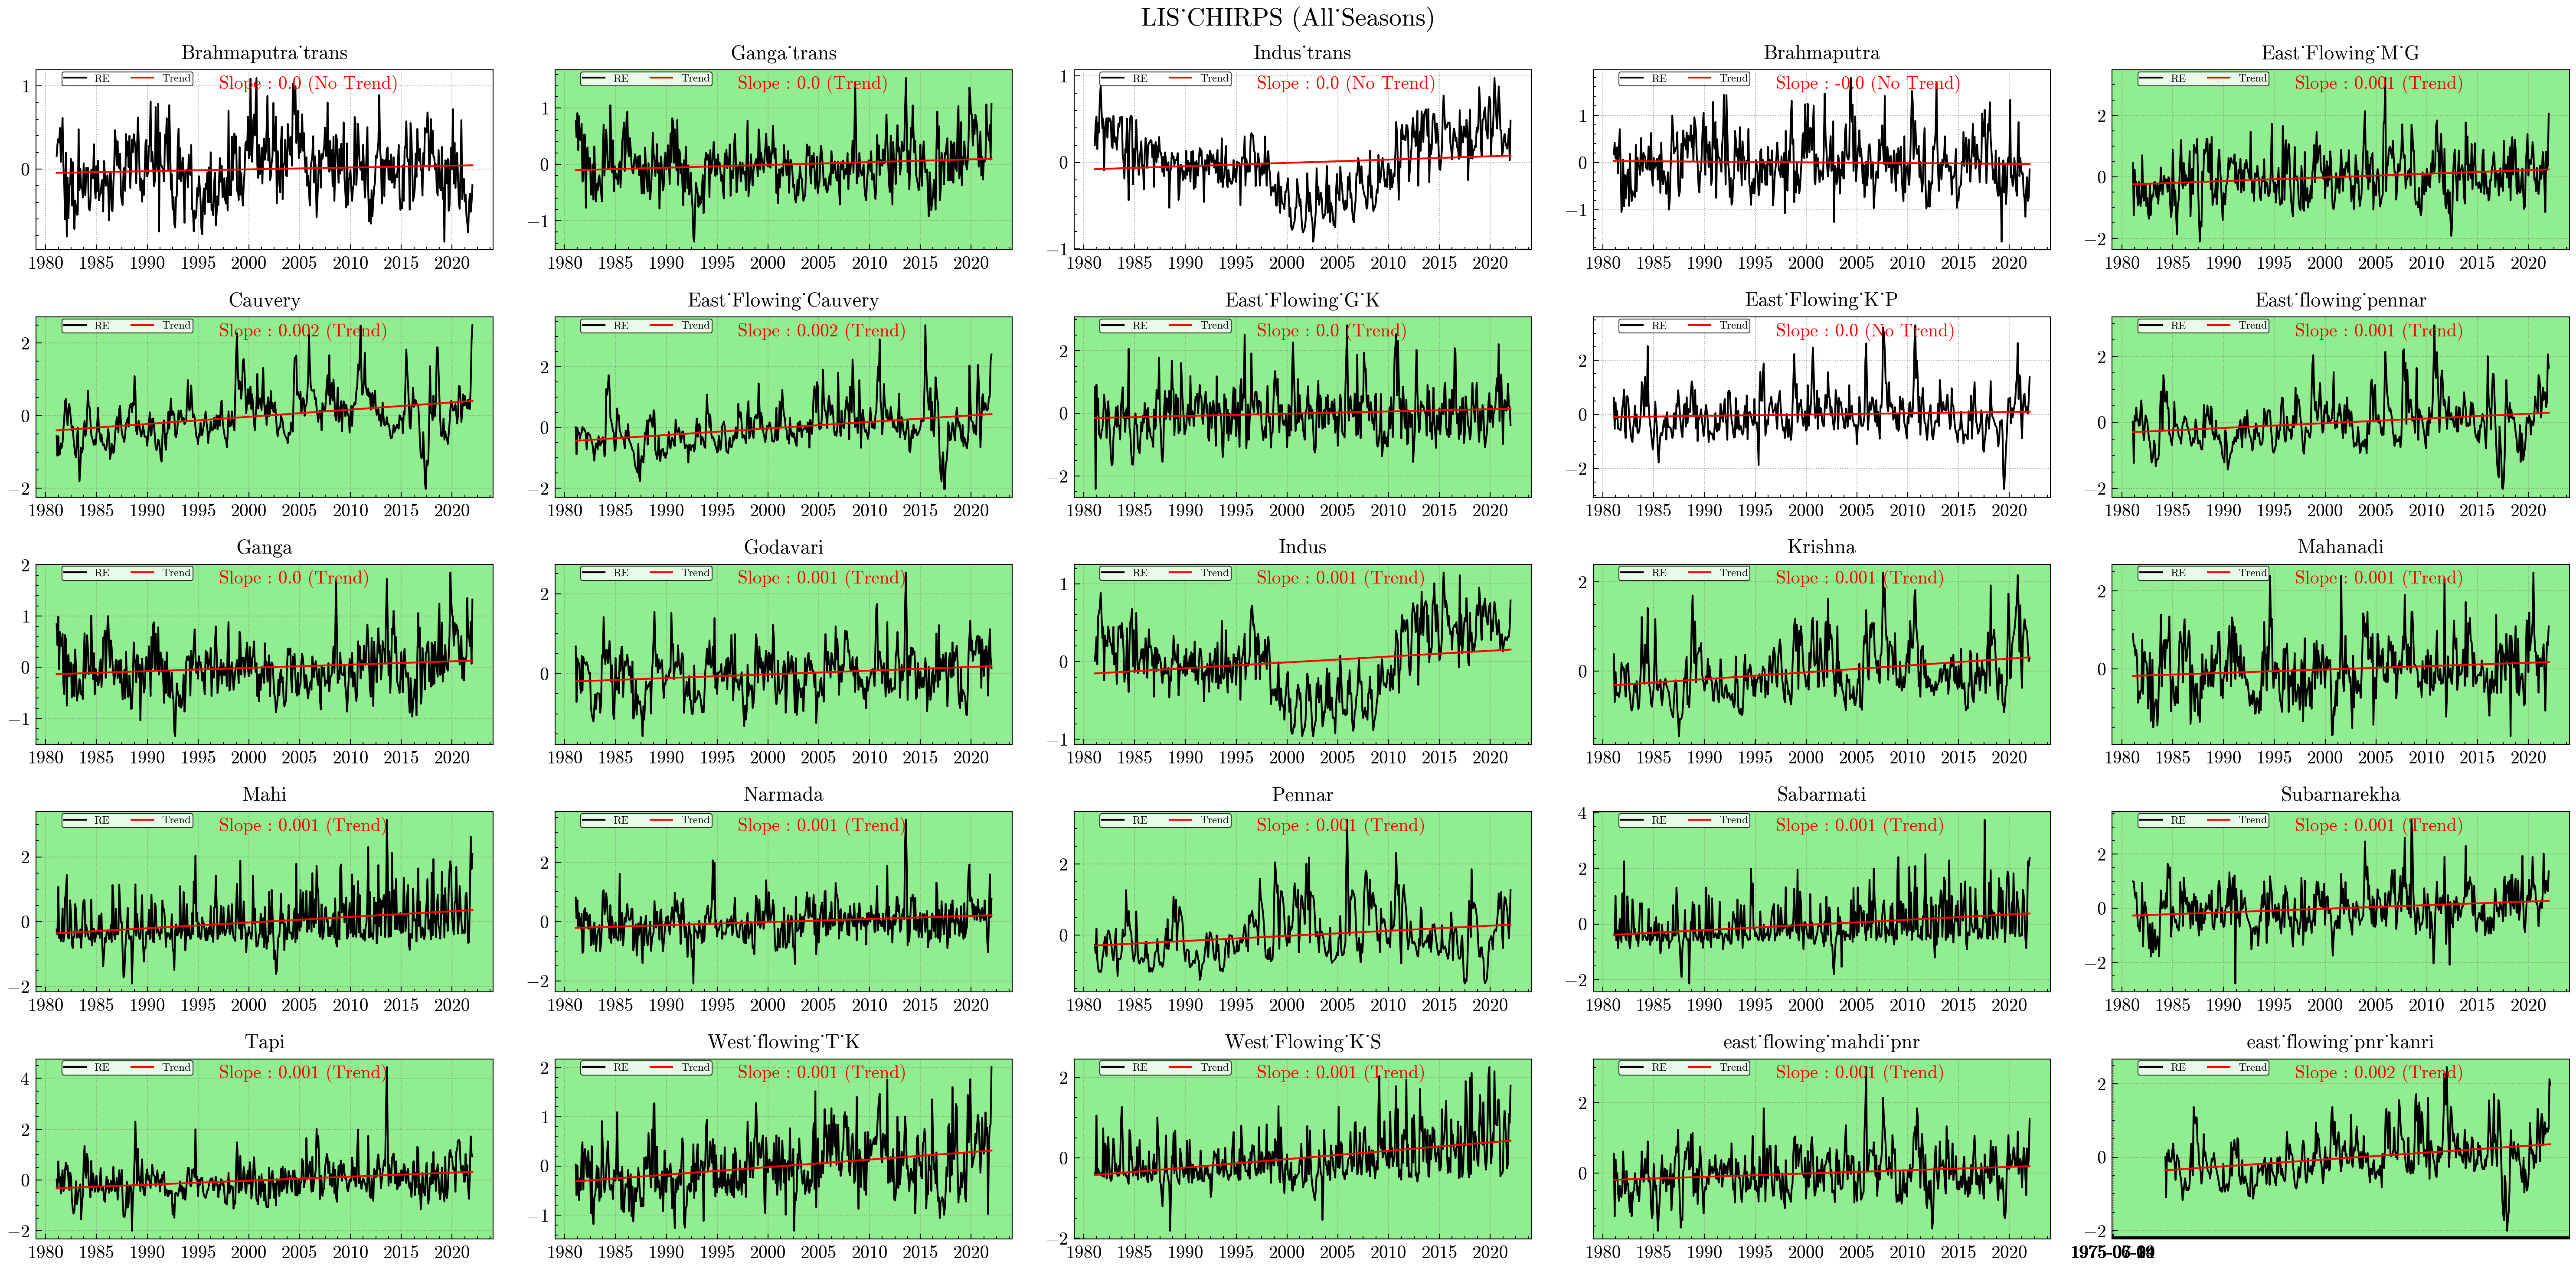

In [65]:
fig, ax = plt.subplots(5,5,figsize=(20,10), facecolor='white', dpi=300)
ax=ax.flatten()

for i in range(25):
        
    import scienceplots
    plt.style.use(['science','no-latex','bright'])
    
    yr=ds_RM.time
    re=ds_RM['RE'].isel(region=i)
    re_s=ds_RM['reg_line'].isel(region=i)
    
    
    lw=1;al=1
    
    ax[i].plot(yr, re, color='Black', label='RE', alpha=al, linewidth=lw)
    ax[i].plot(yr, re_s, color='red', label='Trend', alpha=al, linewidth=lw)
    
    plt.xticks(np.arange(1980, 2020+1, 5.0))
    ax[i].grid(True, color= 'grey', alpha=0.7, linestyle='dotted')
    ax[i].set_facecolor(df['colour'][i])  

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax[i].xaxis.set_tick_params(which='both', bottom=True, top=False)
    ax[i].yaxis.set_tick_params(which='both', left=True, right=False)
    
    
    ax[i].text(0.4, 0.97,f"Slope : {df['slope'][i].round(3)} ({df['sign'][i]})", fontsize=10, color='red',
         ha='left', va='top', transform=ax[i].transAxes)
    
    #ax[i].set_xlabel('$\mathbf{Year}$', fontsize=14)
    #ax[i].set_ylabel('RE', fontsize=14,labelpad=8, weight='bold')
    ax[i].set_title(f'{basin[i]}', fontsize=11)
    
    lgnd=ax[i].legend(loc='center', ncol=2,fontsize=6, bbox_to_anchor=(0.2, 0.95),frameon=True, borderpad=0.2, edgecolor='black')
    frame = lgnd.get_frame()
    frame.set_linewidth(0.5)
    fig.suptitle(f'{model_n[mdl]} (All_Seasons)', fontsize=14,fontweight='bold')

plt.tight_layout()
plt.savefig(f'3_RE_trnd/outputs/{model_n[mdl]}_all.png')
plt.show()